## Assignment 3 - Linear Models

**_Bo Cao,  NUID:  001834167_**


In [1]:
#from __future__ import print_function
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')

# Make plots larger
plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
original = pd.read_csv('flights.csv')
original.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,IF_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0


In [3]:
# Discard the data.
flights = original.drop(['YEAR','MONTH','DAY','DAY_OF_WEEK','TAIL_NUMBER','TAXI_OUT','WHEELS_OFF','SCHEDULED_TIME','ELAPSED_TIME','AIR_TIME','WHEELS_ON','TAXI_IN','CANCELLATION_REASON'],axis=1)
flights = flights.drop(['ORIGIN_AIRPORT','DESTINATION_AIRPORT'],axis=1)
flights.isnull().sum()

AIRLINE                    0
FLIGHT_NUMBER              0
SCHEDULED_DEPARTURE        0
DEPARTURE_TIME           460
DEPARTURE_DELAY          460
DISTANCE                   0
SCHEDULED_ARRIVAL          0
ARRIVAL_TIME             470
ARRIVAL_DELAY            486
DIVERTED                   0
CANCELLED                  0
AIR_SYSTEM_DELAY       10963
SECURITY_DELAY         10963
AIRLINE_DELAY          10963
LATE_AIRCRAFT_DELAY    10963
WEATHER_DELAY          10963
IF_DELAY                   0
dtype: int64

In [4]:
flights_valid = flights.loc[flights['DEPARTURE_TIME']>=0]
flights_valid = flights_valid.loc[flights_valid['DEPARTURE_TIME']>=0]
flights_valid = flights_valid.loc[flights_valid['ARRIVAL_TIME']>=0]
flights_valid = flights_valid.loc[flights_valid['CANCELLED']==0]
flights_valid = flights_valid.loc[flights_valid['DIVERTED']==0]
flights_valid = flights_valid.loc[flights_valid['ARRIVAL_DELAY'] <=180]

flights_valid.isnull().sum()

AIRLINE                    0
FLIGHT_NUMBER              0
SCHEDULED_DEPARTURE        0
DEPARTURE_TIME             0
DEPARTURE_DELAY            0
DISTANCE                   0
SCHEDULED_ARRIVAL          0
ARRIVAL_TIME               0
ARRIVAL_DELAY              0
DIVERTED                   0
CANCELLED                  0
AIR_SYSTEM_DELAY       10477
SECURITY_DELAY         10477
AIRLINE_DELAY          10477
LATE_AIRCRAFT_DELAY    10477
WEATHER_DELAY          10477
IF_DELAY                   0
dtype: int64

In [5]:
flights_valid.head()

,AIRLINE,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,IF_DELAY
0,AS,98,5,2354.0,-11.0,1448,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,0
1,AA,2336,10,2.0,-8.0,2330,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,0
2,US,840,20,18.0,-2.0,2296,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,0
3,AA,258,20,15.0,-5.0,2342,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,0
4,AS,135,25,24.0,-1.0,1448,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,0


In [6]:
flights_valid.describe()

,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,IF_DELAY
count,13401.000000,13401.000000,13401.000000,13401.000000,13401.000000,13401.000000,13401.000000,13401.000000,13401.0,13401.0,2924.000000,2924.000000,2924.000000,2924.000000,2924.000000,13401.000000
mean,2098.324006,1379.351242,1383.800761,8.308932,870.584882,1548.281397,1523.230132,4.071935,0.0,0.0,9.858755,0.095075,16.199384,16.204856,1.447332,0.274233
std,1827.818566,456.629898,468.599095,24.322401,625.051712,483.518139,510.195660,27.409064,0.0,0.0,14.818513,2.312527,25.899558,26.159085,10.023525,0.446144
min,1.000000,5.000000,1.000000,-27.000000,31.000000,2.000000,1.000000,-54.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,676.000000,1015.000000,1016.000000,-4.000000,404.000000,1212.000000,1159.000000,-12.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1499.000000,1400.000000,1404.000000,-1.000000,728.000000,1559.000000,1547.000000,-3.000000,0.0,0.0,3.000000,0.000000,7.000000,3.000000,0.000000,0.000000
75%,3068.000000,1740.000000,1747.000000,11.000000,1111.000000,1930.000000,1928.000000,11.000000,0.0,0.0,17.000000,0.000000,21.000000,22.000000,0.000000,1.000000
max,7438.000000,2359.000000,2359.000000,190.000000,4983.000000,2359.000000,2400.000000,179.000000,0.0,0.0,169.000000,107.000000,179.000000,174.000000,156.000000,1.000000


In [7]:
# Discard the data of Jingan and Xuhui, because we want to find the linear relation between the US post PM2.5 and weather.
data_drop = flights_valid.drop(['DIVERTED','CANCELLED'],axis=1)
data_linear = data_drop.drop(['AIRLINE','FLIGHT_NUMBER','SCHEDULED_DEPARTURE','DEPARTURE_TIME','SCHEDULED_ARRIVAL','ARRIVAL_TIME'],axis=1)
data_linear = data_linear.drop(['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY'],axis=1)
data_linear.describe()

,DEPARTURE_DELAY,DISTANCE,ARRIVAL_DELAY,IF_DELAY
count,13401.000000,13401.000000,13401.000000,13401.000000
mean,8.308932,870.584882,4.071935,0.274233
std,24.322401,625.051712,27.409064,0.446144
min,-27.000000,31.000000,-54.000000,0.000000
25%,-4.000000,404.000000,-12.000000,0.000000
50%,-1.000000,728.000000,-3.000000,0.000000
75%,11.000000,1111.000000,11.000000,1.000000
max,190.000000,4983.000000,179.000000,1.000000


In [8]:
data_linear.head()

,DEPARTURE_DELAY,DISTANCE,ARRIVAL_DELAY,IF_DELAY
0,-11.0,1448,-22.0,0
1,-8.0,2330,-9.0,0
2,-2.0,2296,5.0,0
3,-5.0,2342,-9.0,0
4,-1.0,1448,-21.0,0


In [9]:
data_linear.to_csv('flights1.csv',index=False)

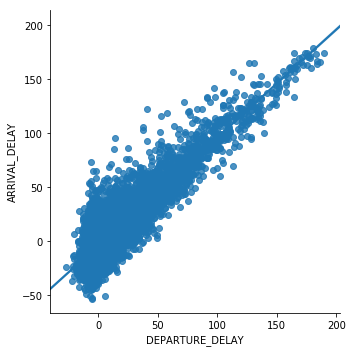

In [10]:
sns.lmplot(x="DEPARTURE_DELAY", y="ARRIVAL_DELAY", data=data_linear)

In [11]:
# from sklearn import linear_model

x = data_linear[["DEPARTURE_DELAY"]]
y = data_linear[["ARRIVAL_DELAY"]]

# Fit the linear model
model = linear_model.LinearRegression()
results = model.fit(x,y)

# Print the coefficients
print (results.intercept_, results.coef_)

[-4.23859272] [[1.00019202]]


In [12]:
# import statsmodels.api as sm
# Note the swap of X and y
model = sm.OLS(y, x)
results = model.fit()
# Statsmodels gives R-like statistical output
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ARRIVAL_DELAY   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                 4.521e+04
Date:                Mon, 22 Oct 2018   Prob (F-statistic):               0.00
Time:                        18:32:48   Log-Likelihood:                -53642.
No. Observations:               13401   AIC:                         1.073e+05
Df Residuals:                   13400   BIC:                         1.073e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
DEPARTURE_DELAY     0.9469      0.004    212.635      0.000       0.938       0.956
==============================================================================
Omnibus:                     1768.002   Durbin-Watson:                   1.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4524.529
Skew:                           0.747   Prob(JB):                         0.00
Kurtosis:                       5.423   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ARRIVAL_DELAY   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                 4.973e+04
Date:                Mon, 22 Oct 2018   Prob (F-statistic):               0.00
Time:                        18:32:49   Log-Likelihood:                -52998.
No. Observations:               13401   AIC:                         1.060e+05
Df Residuals:                   13399   BIC:                         1.060e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -4.2386      0.115    -36.770      0.000      -4.465      -4.013
DEPARTURE_DELAY     1.0002      0.004    223.004      0.000       0.991       1.009
==============================================================================
Omnibus:                     1707.116   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4371.921
Skew:                           0.723   Prob(JB):                         0.00
Kurtosis:                       5.395   Cond. No.                         27.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
# ARRIVAL_DELAY between DEPARTURE_DELAY and DISTANCE

delay_model = ols("ARRIVAL_DELAY ~ DEPARTURE_DELAY + DISTANCE   -1",data = data_linear).fit()

delay_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ARRIVAL_DELAY   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                 2.581e+04
Date:                Mon, 22 Oct 2018   Prob (F-statistic):               0.00
Time:                        18:32:50   Log-Likelihood:                -52947.
No. Observations:               13401   AIC:                         1.059e+05
Df Residuals:                   13399   BIC:                         1.059e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
DEPARTURE_DELAY     0.9923      0.004    225.953      0.000       0.984       1.001
DISTANCE           -0.0040      0.000    -38.273      0.000      -0.004      -0.004
==============================================================================
Omnibus:                     2138.936   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5334.283
Skew:                           0.896   Prob(JB):                         0.00
Kurtosis:                       5.518   Cond. No.                         43.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##  Is the relationship significant?

** Result from above **The coefficient for math is significantly different from 0 because both p-values are 0.000, which are smaller than 0.05. The result state that the coefficients has a very small possibility to be 0.
   
** Result from R ** We can also see the result summary generated by language R. see as follows.

<img src="R1.jpg" style="">

## Are any model assumptions violated?

Usually there are 4 assumptions for a model:  
  
① The Y-value(or the errors,"e") are independent  
② The Y-values can be expressed as a linear function of X variable  
③ Variation of observations around the regression line(the residual SE) is constant  
④ For given value of X,Y values (or the error) are Normally distributed  

The first assumptions base on the knowledge of study design or data collection  
The left 3 assumptions could be check by examinin the residuals or errors.

Language R could print such 4 diagram for the model I built by the plot method.
<img src="R2.jpg" style="">

For the first diagram, no pattern between Residuals and Fitted values, the red line is flat.

For the second diagram, we can see whether the expexted residuals are normally distributed. If the Y-values is, the plot should be on definitely a diagnal line. We can see that from -3 to 1, the line meet the conditions 

The third and Forth diagram could help us to identify non-linear relation and other troubles.

Finding violations with Library(gvlma) in R 

<img src="R3.jpg" style="">

## Is there any multi-colinearity in the model?   

## In the multivariate models are predictor variables independent of all the other predictor variables?

We can identify whether there is multi-colinearity in the model by using Variance Inflation Factor, I use Package faraway in R to gain the result.

<img src="R4.jpg" style="">

because that the vif of each factor is less than 10, even less than 5, there isn't multi-colinearity among the 2 variables.

All the variables in the model are independent with each other according to the Vif result.

## In multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

1. One possibility is to measure the importance of a variable by the magnitude of its regression coefficient. This approach fails because the regression coefficients depend on the underlying scale of measurements.

**DEPARTURE_DELAY**, **DISTANCE** have different scales.

2. Another possibility s to measure the importance of a variable by its observed significance level (P value). However, the distinction between statistical significant and practical importance applies here, too. Even if the predictors are measured on the same scale, a small coefficient that can be estimated precisely will have a small P value, while a large coefficient that is not estimate precisely will have a large P value.

So I try to standardize each variable in the model then compare the coefficient of them.

<img src="R5-summary.jpg">

#### Conclusion
By Comparing the value of the coeffient model after standardize the model, we can see that the significent rank of the two variables is:

DEPARTURE_DELAY > DISTANCE 

## Does the model make sense?

The answer is yes. DEPARTURE_DELAY is the most important variables. The plane can easily get arrival delay.

Also, we can find out that DISTANCE has kind of negative relationship with ARRIVAL_DELAY. The shorter distance flight can get on time flight than the long distance flight.

## Does regularization help? 

Regularization is a method for reducing overfitting. We assess whether the regularization help by comparing the rmes value before and after Using ridge and lasso.

In [15]:
from sklearn import metrics

In [16]:
predictors = ['DEPARTURE_DELAY','DISTANCE']
X = sm.add_constant(data_linear[predictors])
y_mean = np.mean(data_linear['ARRIVAL_DELAY'])
model = sm.OLS(data_linear['ARRIVAL_DELAY'],X)
y_mean

4.071934930229087

In [17]:
ols_fit = model.fit()
y_pred = ols_fit.predict(X)
rmes_ols = np.sqrt(metrics.mean_squared_error(data_linear['ARRIVAL_DELAY'],y_pred))
rmes_ols

12.525441463097556

In [18]:
rmes_ols/y_mean

3.0760416553102616

In [19]:
lasso_fit = model.fit_regularized(L1_wt=1,alpha = 0.05)
lasso_pred = lasso_fit.predict(X)
rmes_lasso = np.sqrt(metrics.mean_squared_error(data_linear['ARRIVAL_DELAY'],lasso_pred))
rmes_lasso

12.52574757769561

In [20]:
rmes_lasso/y_mean

3.076116832002252

In [21]:
ridge_fit = model.fit_regularized(L1_wt=0,alpha = 0.05)
ridge_pred = ridge_fit.predict(X)
rmes_ridge = np.sqrt(metrics.mean_squared_error(data_linear['ARRIVAL_DELAY'],ridge_pred))
rmes_ridge

12.526380269464036

In [22]:
rmes_ridge/y_mean

3.076272210656201

# logistic linear model

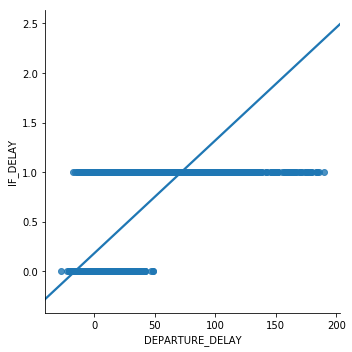

In [27]:
sns.lmplot(y='IF_DELAY', x='DEPARTURE_DELAY', data=data_linear, ci=None)

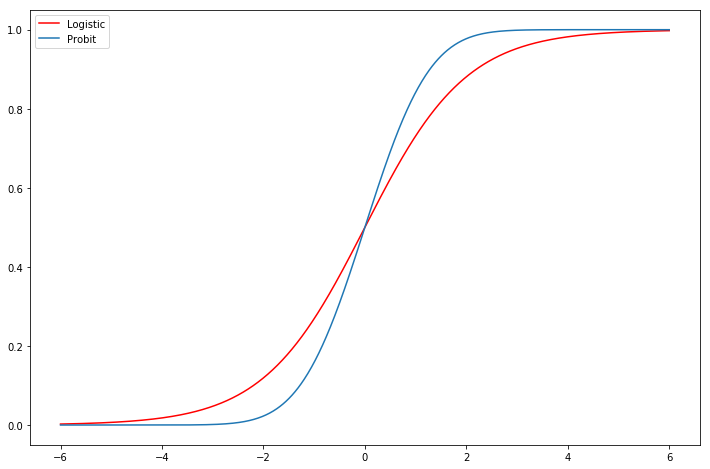

In [26]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
support = np.linspace(-6, 6, 1000)
ax.plot(support, stats.logistic.cdf(support), 'r-', label='Logistic')
ax.plot(support, stats.norm.cdf(support), label='Probit')
ax.legend();

In [29]:
departure_delay_model = sm.Logit(data_linear['IF_DELAY'], data_linear['DEPARTURE_DELAY']).fit()
departure_delay_model.summary()

Optimization terminated successfully.
         Current function value: 0.573797
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               IF_DELAY   No. Observations:                13401
Model:                          Logit   Df Residuals:                    13400
Method:                           MLE   Df Model:                            0
Date:                Tue, 23 Oct 2018   Pseudo R-squ.:                 0.02320
Time:                        01:57:15   Log-Likelihood:                -7689.5
converged:                       True   LL-Null:                       -7872.1
                                        LLR p-value:                       nan
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
DEPARTURE_DELAY     0.0839      0.002     37.215      0.000       0.080       0.088
===================================================================================
"""

## Is the relationship significant?

by seeing the summary of the logistic model

In [30]:
predictors = ['DEPARTURE_DELAY','DISTANCE']
model_logistic = sm.Logit(data_linear['IF_DELAY'],data_linear[predictors]).fit()
model_logistic.summary()

Optimization terminated successfully.
         Current function value: 0.390252
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               IF_DELAY   No. Observations:                13401
Model:                          Logit   Df Residuals:                    13399
Method:                           MLE   Df Model:                            1
Date:                Tue, 23 Oct 2018   Pseudo R-squ.:                  0.3357
Time:                        02:02:30   Log-Likelihood:                -5229.8
converged:                       True   LL-Null:                       -7872.1
                                        LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
DEPARTURE_DELAY     0.1354      0.003     49.476      0.000       0.130       0.141
DISTANCE           -0.0018   3.39e-05    -52.837      0.000      -0.002      -0.002
===================================================================================
"""

Two p-value are small enough to inform that all the three variables is significant.

## Are any model assumption violated?

glvma package of R doesn't support evaluating the assumption of a logistic model.

We are trying to find a new method on it.

## Cross-validate the model. How well did it do ?

In [31]:
rmse = np.sqrt(metrics.mean_squared_error(data_linear['IF_DELAY'], model_logistic.predict(data_linear[predictors])))
# root mean square error
rmse

0.3387854813138216

In [32]:
from sklearn.cross_validation import KFold, cross_val_score, train_test_split

In [33]:
scores = []
for train, test in KFold (len(data_linear[predictors]), n_folds=10):
    model_2 = sm.Logit(data_linear['IF_DELAY'].iloc[train], data_linear[predictors].iloc[train]).fit()
    y_pred = model_2.predict(data_linear[predictors].iloc[test])
    y_true = data_linear['IF_DELAY'].iloc[test]
    score = np.sqrt(metrics.mean_squared_error(y_true,y_pred))
    scores.append(score)
scores

Optimization terminated successfully.
         Current function value: 0.393617
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.390783
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394219
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.391012
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392950
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.389423
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.386765
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.385329
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388210
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.389774
  

[0.31919890377318366,
 0.33250605245995946,
 0.32108970971140643,
 0.33260135193609996,
 0.33014588664502703,
 0.34237038143482085,
 0.35901632427347635,
 0.35894685447837443,
 0.35327630512700886,
 0.3382568049359062]

In [34]:
np.mean(scores)

0.33874085747752636